In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.python.ops import rnn, rnn_cell

# Hyperparameters

In [2]:
test_length = 2000
sampling_rate = 200
striding = 100

In [3]:
def downgrade_and_feature(array):
    nchannels = array.shape[0]
    data_length = array.shape[1]
    
    temp = np.zeros(data_length)
    
    for j in range(data_length):
        for i in range(nchannels):
            temp[j] += array[i][j]
        temp[j]/=nchannels
    
    reduced_length = int(data_length/striding)

    averages = np.zeros(reduced_length, dtype = np.float32)   
    variations = np.zeros(reduced_length, dtype = np.float32)
    
    for i in range(reduced_length):
        averages[i] = np.average(temp[striding*i:striding*(i+1)])
        variations[i] = np.var(temp[striding*i:striding*(i+1)])
        
    return {'averages' : averages,'variations' : variations}

In [4]:
def normal_data_load(patient_number, iswakeup=0):
    try :
        input_folder_path = '/home/maestoj/medical_analysis/eeg_normal'
        input_data_name = 'data{}s.csv'.format(patient_number)
        if iswakeup == 1:
            input_data_name = 'data{}w.csv'.format(patient_number)
        input_data_path = os.path.join(input_folder_path,input_data_name)
        input_file = open(input_data_path,'r',newline='')
        reader = csv.reader(input_file, delimiter=',')
        print("{} is loaded".format(input_data_name))
        temp = []
        for row in reader:
            temp.append(row)
        temp = np.array(temp, dtype=np.float32)
        temp = np.transpose(temp)
        return temp
    except FileNotFoundError:
        print("No such File")
        temp = []
        temp = np.array(temp)
        return temp

In [5]:
def dataload(patient_number, dataset_number):
    try :
        input_folder_path = '/home/maestoj/medical_analysis/eeg_csv'
        input_data_name = 'data{}_{}.csv'.format(patient_number,dataset_number)
        input_data_path = os.path.join(input_folder_path,input_data_name)
        input_file = open(input_data_path,'r',newline='')
        reader = csv.reader(input_file, delimiter=',')
        print("{} is loaded".format(input_data_name))
        temp = []
        for row in reader:
            temp.append(row)
        temp = np.array(temp, dtype=np.float32)
        temp = np.transpose(temp)
        return temp
    except FileNotFoundError:
        print("No such File")
        temp = []
        temp = np.array(temp)
        return temp

In [6]:
def time_axis_maker(array, sec_per_cell,init = 0):
    final = init + sec_per_cell*(len(array)-1)
    return np.linspace(init,final,len(array))

In [7]:
temp = normal_data_load(1,0)
print(temp.shape)
result = downgrade_and_feature(temp)
print(result['averages'].shape)
print(result['variations'].shape)

data1s.csv is loaded
(22, 54000)
(540,)
(540,)


In [8]:
def test_set_generator(patient_number, iswakeup=0):
    result = downgrade_and_feature(normal_data_load(patient_number,iswakeup))
    
    original_length = len(result['averages'])
    input_data = np.zeros((2,test_length))
    for i in range(test_length):
        index = i%original_length
        input_data[0][i] = result['averages'][index]
        input_data[1][i] = result['variations'][index]

    return input_data

In [9]:
def test_set_generator2(patient_number, dataset_number):
    result = downgrade_and_feature(dataload(patient_number,dataset_number))
    
    original_length = len(result['averages'])
    input_data = np.zeros((2,test_length))
    for i in range(test_length):
        index = i%original_length
        input_data[0][i] = result['averages'][index]
        input_data[1][i] = result['variations'][index]

    return input_data

data1s.csv is loaded


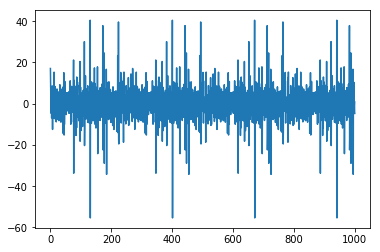

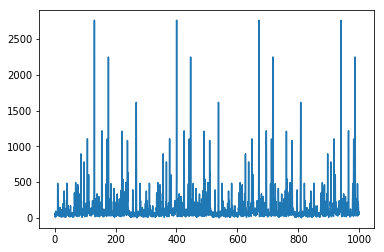

In [10]:
result = test_set_generator(1,0)
time = time_axis_maker(result[0], striding/sampling_rate)
plt.plot(time,result[0])
plt.show()
plt.plot(time, result[1])
plt.show()

In [13]:
restorer = tf.train.import_meta_graph('rnn_v6.meta')
sess = tf.Session()
restorer.restore(sess, tf.train.latest_checkpoint('./'))
hypo_vars = tf.get_collection('hypothesis')
input_vars = tf.get_collection('test_input')
test_x = input_vars[0]
temp_test_outputs = hypo_vars[0]

Patient 1 wake_up 0
data1s.csv is loaded


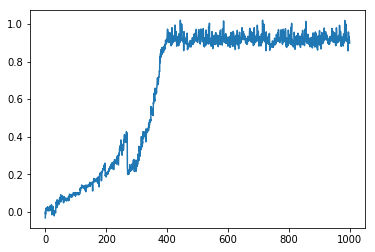

Patient 1 wake_up 1
data1w.csv is loaded


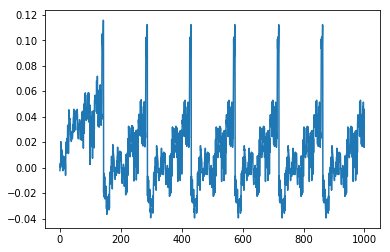

Patient 2 wake_up 0
data2s.csv is loaded


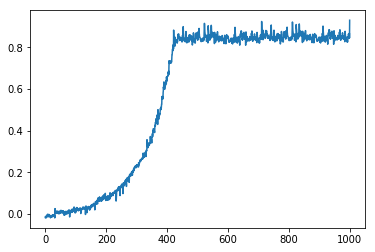

Patient 2 wake_up 1
data2w.csv is loaded


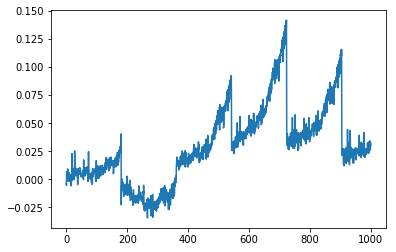

Patient 3 wake_up 0
No such File
Patient 3 wake_up 1
data3w.csv is loaded


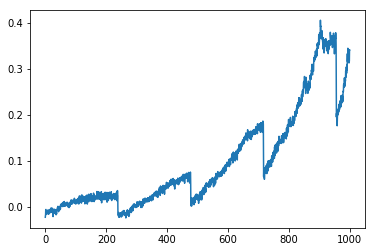

Patient 4 wake_up 0
data4s.csv is loaded


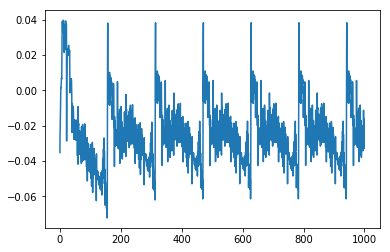

Patient 4 wake_up 1
data4w.csv is loaded


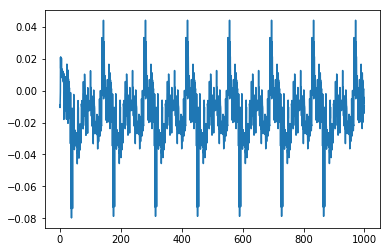

Patient 5 wake_up 0
data5s.csv is loaded


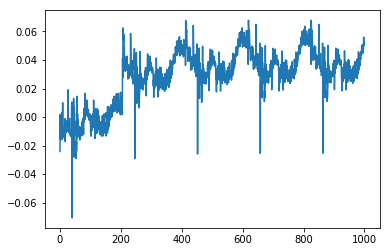

Patient 5 wake_up 1
data5w.csv is loaded


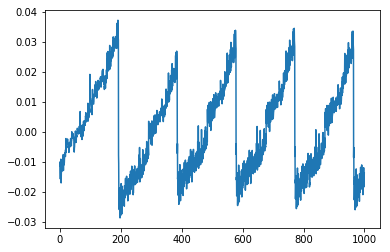

Patient 6 wake_up 0
data6s.csv is loaded


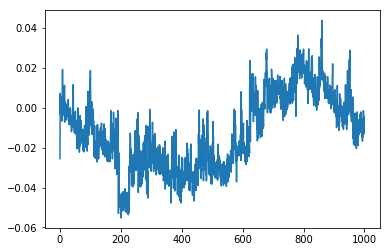

Patient 6 wake_up 1
data6w.csv is loaded


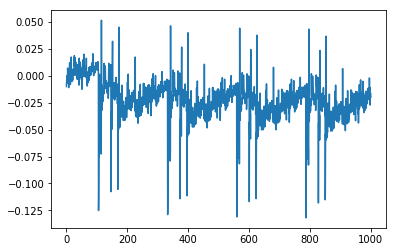

Patient 7 wake_up 0
data7s.csv is loaded


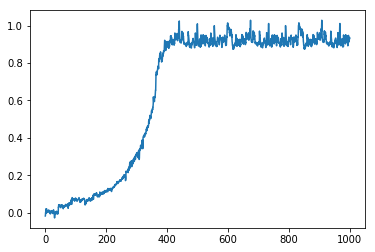

Patient 7 wake_up 1
data7w.csv is loaded


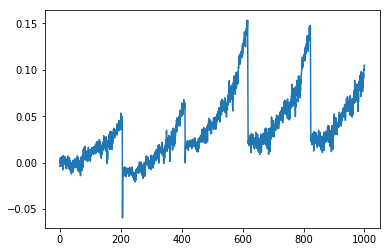

Patient 8 wake_up 0
No such File
Patient 8 wake_up 1
data8w.csv is loaded


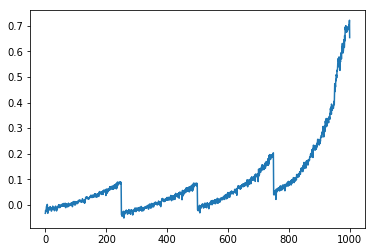

Patient 9 wake_up 0
data9s.csv is loaded


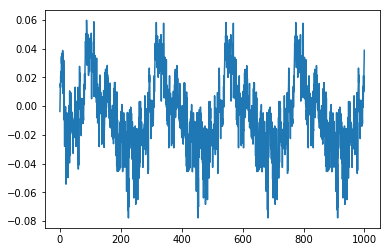

Patient 9 wake_up 1
data9w.csv is loaded


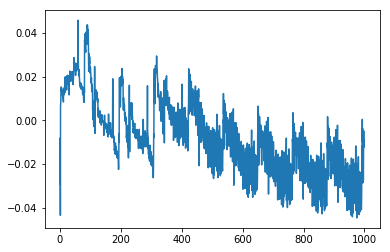

Patient 10 wake_up 0
data10s.csv is loaded


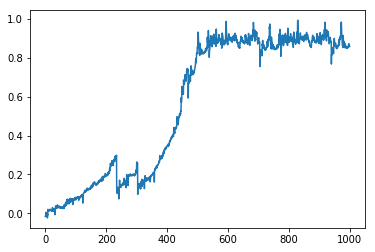

Patient 10 wake_up 1
data10w.csv is loaded


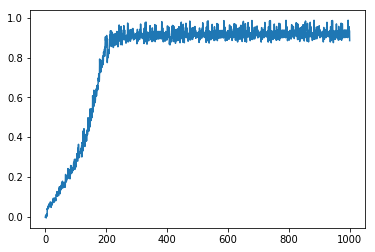

In [14]:
for i in range(1,11):
    for j in range(2):
        try :
            patient_number = i
            iswakeup=j
            print("Patient {} wake_up {}".format(patient_number,iswakeup))
            input_data = test_set_generator(patient_number, iswakeup)
            time = time_axis_maker(input_data[0],striding/sampling_rate)
            input_data = np.reshape(input_data,[1,2,test_length])
            plt.plot(time, sess.run(temp_test_outputs[0], feed_dict = {test_x : input_data}))
            plt.show()
        except IndexError:
            continue

In [11]:
seizure_file = open('seizure_times.csv','r',newline='')
reader = csv.reader(seizure_file,delimiter=',')
onset_times_temp=[]

for row in reader:
    onset_times_temp.append(row)
    
onset_times = []
total_patient = len(onset_times_temp)
event_number = np.zeros(total_patient,dtype=np.int32)
#number of events of (i+1) patient = event_number[i]

for i in range(total_patient):
    event_number[i] = len(onset_times_temp[i])-1
print(event_number)

[ 7  7  6  3 10  1  7 13 16  8  8  5  3  6 31  8  2  4]


In [ ]:
for i in range(1,total_patient+1):
    for j in range(1,event_number[i-1]+1):
        if i <8:
            continue;
        try:
            patient_number = i
            dataset_number = j
            print("Patient {} dataset {}".format(patient_number,dataset_number))
            input_data = test_set_generator2(patient_number, dataset_number)
            time = time_axis_maker(input_data[0],striding/sampling_rate)
            
            input_data = np.reshape(input_data,[1,2,test_length])
            temp = sess.run(temp_test_outputs[0], feed_dict = {test_x : input_data})
            for k in range(test_length):
                if temp[k]>0.5:
                    break;
            print("Onset predicted in {}".format(k*striding/sampling_rate))
            plt.plot(time,temp)
            plt.show()
        except IndexError:
            continue

Patient 8 dataset 1
data8_1.csv is loaded
